# Are there distinct patterns of Ring Bus usage among METU students, and how do these patterns differ in terms of routes, time of day, and trip purposes?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

In [3]:
df = pd.read_csv('../data/metu_ring_processed.csv')
df.head()

,Gender,Residence,Study_Level,Faculty,Grad_School,Visiting_Faculty_GradSchool,Affiliation_Program,Weekday_Schedule_Satisfaction,Weekend_Schedule_Satisfaction,Understanding_Routes,...,TimeWkend_Afternoon_15:00_19:00,TimeWkend_Late_19:00_23:00,Total_Usage_Score,Problem_Severity_Index,Heavy_User,Residence_Simplified,Route_Count,Purpose_Count,Reason_Count,UseMore_Binary
0,Male,"East Dorms (1st Dorm, 2nd Dorm, 16th Guesthous...",Undergraduate (Bachelor’s),Faculty of Engineering,NaN,NaN,NaN,2,1,1.0,...,1,1,5,4.125,0,East_Dorms,2,3,2,1.0
1,Female,"West Dorms (Isa Demiray Student Dormitory, 19t...",Undergraduate (Bachelor’s),Faculty of Arts and Sciences,NaN,NaN,NaN,4,3,3.0,...,0,1,8,2.500,1,West_Dorms,2,6,1,1.0
2,Female,"West Dorms (Isa Demiray Student Dormitory, 19t...",Undergraduate (Bachelor’s),Faculty of Engineering,NaN,NaN,NaN,2,2,5.0,...,1,1,8,3.125,1,West_Dorms,3,5,2,1.0
3,Male,"West Dorms (Isa Demiray Student Dormitory, 19t...",Undergraduate (Bachelor’s),Faculty of Engineering,NaN,NaN,NaN,3,2,5.0,...,0,0,8,2.500,1,West_Dorms,1,2,2,1.0
4,Male,Off-campus (within walking distance),Undergraduate (Bachelor’s),Faculty of Economic and Administrative Sciences,NaN,NaN,NaN,4,3,2.0,...,0,1,5,2.250,1,Off_Campus_Near,4,4,1,1.0


In [4]:
# ============================================================================
# ВАЖНОЕ ПРИМЕЧАНИЕ О МЕТОДОЛОГИИ
# ============================================================================
print("="*80)
print("METHODOLOGICAL NOTE: BEHAVIORAL SEGMENTATION")
print("="*80)
print("""
This analysis identifies DISTINCT BEHAVIORAL PATTERNS in Ring Bus usage.
It is a DESCRIPTIVE segmentation based on observed behavior (routes, times, purposes).

⚠ IMPORTANT: This is NOT a causal analysis.
- We are describing HOW users behave, not WHY they behave that way.
- Segments are identified based on behavioral similarities, not demographic or satisfaction differences.
- Any associations between segments and satisfaction/frequency are CORRELATIONAL, not causal.

The segmentation helps answer:
- "What types of usage patterns exist among METU students?"
- "How do these patterns differ in terms of routes, time, and purposes?"

It does NOT answer:
- "Why do some students use the bus more than others?" (causal question)
- "What causes satisfaction differences?" (causal question)
""")
print("="*80)
print()

# ============================================================================
# ШАГ 1: Подготовка матрицы поведения
# ============================================================================

# Выделяем колонки для матрицы поведения
route_cols = [col for col in df.columns if col.startswith('Route_')]
time_cols = [col for col in df.columns if col.startswith('TimeWkday_') or col.startswith('TimeWkend_')]
purpose_cols = [col for col in df.columns if col.startswith('Purpose_')]

# Исключаем агрегированные колонки (Count) из матрицы поведения
route_cols = [col for col in route_cols if col != 'Route_Count']
purpose_cols = [col for col in purpose_cols if col != 'Purpose_Count']

# Собираем матрицу поведения
behavior_cols = route_cols + time_cols + purpose_cols
# Явно исключаем любые колонки с "Count" в названии (на случай, если есть другие)
behavior_cols = [col for col in behavior_cols if 'Count' not in col]

print(f"Routes: {len(route_cols)} columns (excluding Route_Count)")
print(f"Time slots: {len(time_cols)} columns")
print(f"Purposes: {len(purpose_cols)} columns (excluding Purpose_Count)")
print(f"Total behavior features: {len(behavior_cols)}")

X = df[behavior_cols].copy()

# Удаляем строки, где все значения = 0 (не использовали Ring Bus)
X = X[(X.sum(axis=1) > 0)]

print(f"\nBehavior matrix shape: {X.shape}")
print(f"Non-zero rows: {len(X)}")

# Сохраняем индексы для дальнейшего анализа
valid_indices = X.index
df_analysis = df.loc[valid_indices].copy()

METHODOLOGICAL NOTE: BEHAVIORAL SEGMENTATION

This analysis identifies DISTINCT BEHAVIORAL PATTERNS in Ring Bus usage.
It is a DESCRIPTIVE segmentation based on observed behavior (routes, times, purposes).

⚠ IMPORTANT: This is NOT a causal analysis.
- We are describing HOW users behave, not WHY they behave that way.
- Segments are identified based on behavioral similarities, not demographic or satisfaction differences.
- Any associations between segments and satisfaction/frequency are CORRELATIONAL, not causal.

The segmentation helps answer:
- "What types of usage patterns exist among METU students?"
- "How do these patterns differ in terms of routes, time, and purposes?"

It does NOT answer:
- "Why do some students use the bus more than others?" (causal question)
- "What causes satisfaction differences?" (causal question)


Routes: 7 columns (excluding Route_Count)
Time slots: 8 columns
Purposes: 8 columns (excluding Purpose_Count)
Total behavior features: 23

Behavior matrix shape:

In [5]:
# ============================================================================
# ШАГ 2: Latent Class Analysis (LCA) - используем альтернативу через кластеризацию
# ============================================================================

# Поскольку LCA требует специальных библиотек, используем Jaccard distance + hierarchical clustering
# Это даёт похожие результаты для бинарных данных

def jaccard_distance(x, y):
    """Вычисляет расстояние Жаккара между двумя бинарными векторами"""
    intersection = np.logical_and(x, y).sum()
    union = np.logical_or(x, y).sum()
    if union == 0:
        return 1.0
    return 1 - (intersection / union)

# Вычисляем попарные расстояния (выборочно для больших данных)
print("\nComputing Jaccard distances...")
if len(X) > 500:
    # Для больших данных используем выборку
    sample_size = 500
    sample_idx = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X.iloc[sample_idx].values
    distances = pdist(X_sample, metric=jaccard_distance)
    linkage_matrix = linkage(distances, method='ward')
    
    # Находим оптимальное число кластеров по silhouette
    # Преобразуем сжатую матрицу расстояний в квадратную форму
    distance_matrix = squareform(distances)
    np.fill_diagonal(distance_matrix, 0)  # Диагональ должна быть 0
    
    best_k = 3
    best_silhouette = -1
    for k in range(2, 7):
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        if len(np.unique(labels)) > 1:
            sil_score = silhouette_score(distance_matrix, labels, metric='precomputed')
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_k = k
    
    # Применяем кластеризацию ко всем данным
    print(f"Best k (from sample): {best_k}")
    # Для всех данных используем k-means с Jaccard distance
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    
    # Альтернатива: используем k-modes для категориальных данных
    try:
        from kmodes.kmodes import KModes
        # Конвертируем в категориальные данные
        X_categorical = X.astype(str).values
        kmodes = KModes(n_clusters=best_k, init='Huang', n_init=10, verbose=0)
        cluster_labels = kmodes.fit_predict(X_categorical)
    except ImportError:
        # Если kmodes не установлен, используем простой k-means на расстояниях
        print("kmodes not available, using alternative method...")
        # Используем PCA для уменьшения размерности, затем k-means
        from sklearn.decomposition import PCA
        from sklearn.cluster import KMeans
        
        pca = PCA(n_components=min(20, X.shape[1]))
        X_pca = pca.fit_transform(X)
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_pca)
else:
    # Для малых данных вычисляем все расстояния
    distances = pdist(X.values, metric=jaccard_distance)
    linkage_matrix = linkage(distances, method='ward')
    
    # Находим оптимальное k
    # Преобразуем сжатую матрицу расстояний в квадратную форму
    distance_matrix = squareform(distances)
    np.fill_diagonal(distance_matrix, 0)  # Диагональ должна быть 0
    
    best_k = 3
    best_silhouette = -1
    for k in range(2, 7):
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        if len(np.unique(labels)) > 1:
            sil_score = silhouette_score(distance_matrix, labels, metric='precomputed')
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_k = k
    
    cluster_labels = fcluster(linkage_matrix, best_k, criterion='maxclust') - 1

# Добавляем метки кластеров
df_analysis['Segment'] = cluster_labels
X['Segment'] = cluster_labels

print(f"\nNumber of segments: {best_k}")
print(f"Segment distribution:")
segment_counts = df_analysis['Segment'].value_counts().sort_index()
print(segment_counts)

# Проверка: сегменты не должны быть слишком маленькими
min_segment_size = len(df_analysis) * 0.05  # Минимум 5% от выборки

print(f"\nSegment size check:")
print(f"Minimum acceptable size: {min_segment_size:.0f} (5% of sample)")
for seg, count in segment_counts.items():
    pct = (count / len(df_analysis)) * 100
    status = "✓ OK" if count >= min_segment_size else "⚠ TOO SMALL"
    print(f"  Segment {seg+1}: {count} ({pct:.1f}%) {status}")

if any(segment_counts < min_segment_size):
    print("\n⚠ WARNING: Some segments are too small. Consider adjusting clustering parameters.")
else:
    print("\n✓ All segments meet minimum size requirement.")



Computing Jaccard distances...

Number of segments: 3
Segment distribution:
Segment
0    144
1     90
2     91
Name: count, dtype: int64

Segment size check:
Minimum acceptable size: 16 (5% of sample)
  Segment 1: 144 (44.3%) ✓ OK
  Segment 2: 90 (27.7%) ✓ OK
  Segment 3: 91 (28.0%) ✓ OK

✓ All segments meet minimum size requirement.


In [6]:
# ============================================================================
# ШАГ 3: Анализ профилей сегментов
# ============================================================================

# Вычисляем вероятности для каждого сегмента
segment_profiles = {}
for seg in sorted(df_analysis['Segment'].unique()):
    seg_data = X[X['Segment'] == seg].drop('Segment', axis=1)
    # Вероятность выбора каждой опции
    probabilities = seg_data.mean()
    segment_profiles[seg] = probabilities

# Создаём DataFrame для визуализации
profile_df = pd.DataFrame(segment_profiles).T
profile_df.index = [f'Segment {i+1}' for i in profile_df.index]


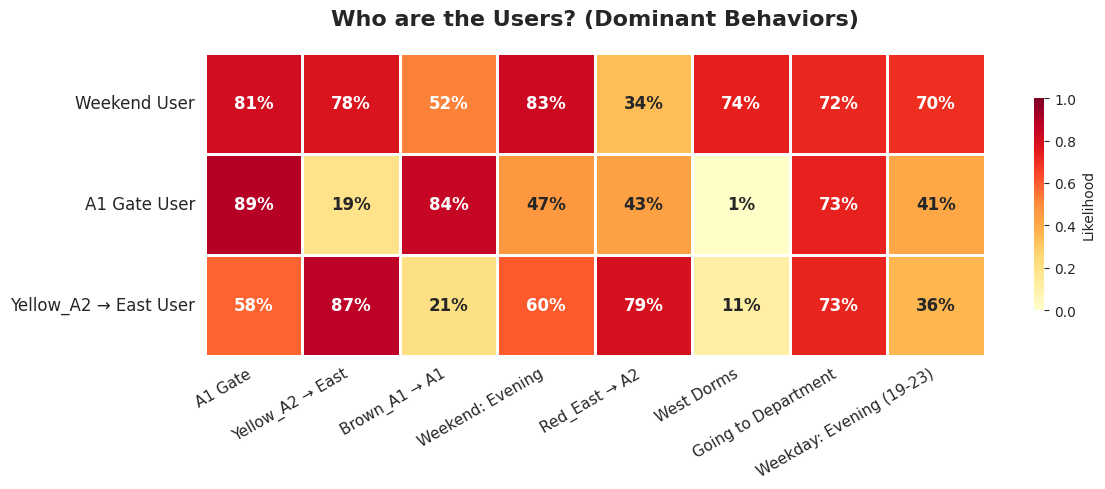

In [7]:
N_TOP_FEATURES = 8  # reduce number of features for clearer plot

# rebuild cleaned column names if needed (keeps your original replacements)
route_cols_clean = [col.replace('Route_', '').replace('___', ' → ') for col in route_cols]
time_cols_clean = [col.replace('TimeWkday_', 'WD: ').replace('TimeWkend_', 'WE: ')
                   .replace('_', ' ').replace('08:00', '08').replace('11:00', '11')
                   .replace('15:00', '15').replace('19:00', '19').replace('23:00', '23')
                   for col in time_cols]
purpose_cols_clean = [col.replace('Purpose_Going_to_', '').replace('_', ' ')
                      for col in purpose_cols]

all_cols_clean = route_cols_clean + time_cols_clean + purpose_cols_clean
profile_df.columns = all_cols_clean

# select top features
all_probs = profile_df.max(axis=0).sort_values(ascending=False)
top_features = all_probs.head(N_TOP_FEATURES).index.tolist()
profile_df_top = profile_df[top_features].copy()

# =========================================================
# CLEAN AND READABLE VISUALIZATION (Yellow-Red Palette)
# =========================================================

# Dictionary for user-friendly renaming
rename_map = {
    'WD: Morning 08 11': 'Weekday: Morning (08-11)',
    'WD: Noon 11 15': 'Weekday: Noon (11-15)',
    'WD: Afternoon 15 19': 'Weekday: Afternoon (15-19)',
    'WD: Late 19 23': 'Weekday: Evening (19-23)',
    'WE: Morning 08 11': 'Weekend: Morning',
    'WE: Noon 11 15': 'Weekend: Noon',
    'WE: Afternoon 15 19': 'Weekend: Afternoon',
    'WE: Late 19 23': 'Weekend: Evening',
    'department': 'Going to Department',
    'West Dorms': 'West Dorms',
    'East Dorms': 'East Dorms',
    'A1 Gate': 'A1 Gate',
    'A2 Gate': 'A2 Gate',
}

# Apply renaming to columns
profile_df_top.columns = [rename_map.get(col, col) for col in profile_df_top.columns]

# Generate simplified labels for rows (Segments)
new_labels = []
for i, (idx, row) in enumerate(profile_df_top.iterrows()):
    top_feature = row.idxmax()
    # If the feature name is very long, simplify it for the row label
    simple_feat = top_feature.split(":")[0] if ":" in top_feature else top_feature
    label = f"{simple_feat} User"
    new_labels.append(label)

profile_df_top.index = new_labels

# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(
    profile_df_top,
    annot=True,
    fmt='.0%',  # Show as percentage (e.g., 81%)
    annot_kws={'fontsize': 12, 'weight': 'bold'},
    cmap='YlOrRd',  # <--- CHANGED TO YELLOW-ORANGE-RED
    linewidths=1,
    linecolor='white',
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Likelihood', 'shrink': 0.7}
)

# Titles and Axis
ax.set_title('Who are the Users? (Dominant Behaviors)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)

# Ticks
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.xticks(rotation=30, ha='right') 

plt.tight_layout()
plt.show()

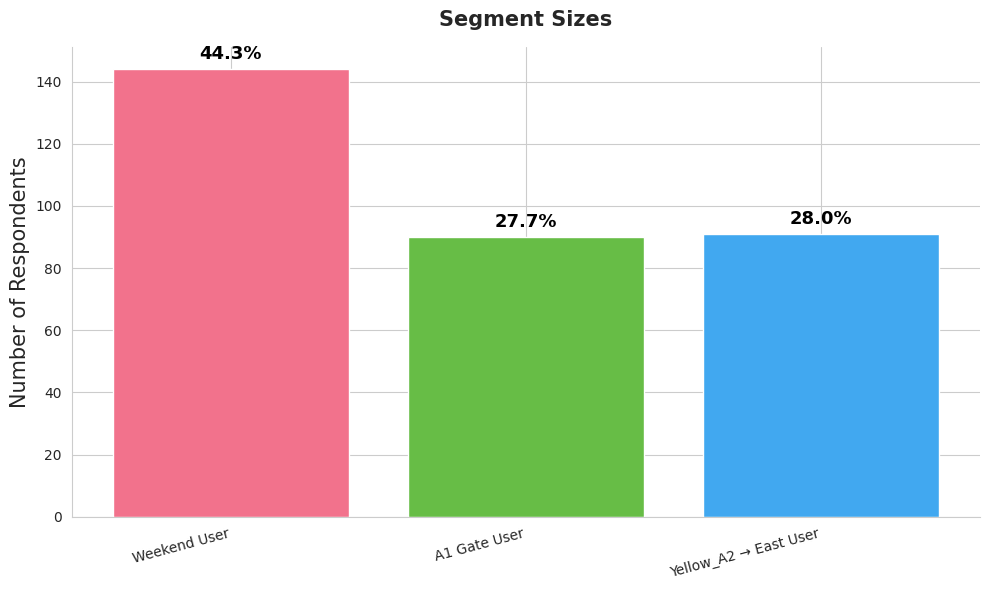

In [12]:
# ============================================================================
# FIGURE 2: Размеры сегментов (Обновленный)
# ============================================================================

# 1. Prepare Data
segment_counts = df_analysis['Segment'].value_counts().sort_index()
segment_pct = (segment_counts / len(df_analysis) * 100).round(1)

# 2. Get Readable Labels
# Try to use labels from the heatmap DataFrame if available and matching size
if 'profile_df_top' in locals() and len(profile_df_top) == len(segment_counts):
    x_labels = profile_df_top.index.tolist()
else:
    # Fallback to generic labels if names aren't available
    x_labels = [f'Segment {i+1}' for i in segment_counts.index]

# 3. Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Custom palette (Pink, Green, Blue)
custom_colors = ['#F2728C', '#67BD46', '#41A8F0']
# Expand if more than 3 segments
if len(segment_counts) > len(custom_colors):
    custom_colors = sns.color_palette("husl", len(segment_counts))

bars = ax.bar(x_labels, segment_counts.values, color=custom_colors[:len(segment_counts)])

# 4. Styling
ax.set_title('Segment Sizes', fontsize=15, fontweight='bold', pad=15)
ax.set_ylabel('Number of Respondents', fontsize=15)
ax.set_xlabel('', fontsize=15)

# Remove top and right spines
sns.despine(top=True, right=True)

# 5. Add ONLY Percentages
for bar, pct in zip(bars, segment_pct.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{pct}%',  # <--- Only percentage
             ha='center', va='bottom', fontsize=13, fontweight='bold', color='black')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# ============================================================================
# ШАГ 4: Интерпретация сегментов (автоматическая)
# ============================================================================

print("\n" + "="*80)
print("SEGMENT INTERPRETATION")
print("="*80)

segment_names = {}
for seg in sorted(df_analysis['Segment'].unique()):
    seg_probs = segment_profiles[seg]
    
    # Топ-3 маршрута
    top_routes = seg_probs[route_cols].sort_values(ascending=False).head(3)
    route_names = [col.replace('Route_', '').replace('___', ' → ') 
                   for col in top_routes.index]
    top_route = route_names[0] if route_names else "Mixed"
    
    # Топ-3 времени
    top_times = seg_probs[time_cols].sort_values(ascending=False).head(3)
    time_names = [col.replace('TimeWkday_', 'WD: ').replace('TimeWkend_', 'WE: ')
                  .replace('_', ' ') for col in top_times.index]
    top_time = time_names[0] if time_names else "Mixed"
    
    # Топ-3 цели
    top_purposes = seg_probs[purpose_cols].sort_values(ascending=False).head(3)
    purpose_names = [col.replace('Purpose_Going_to_', '').replace('_', ' ') 
                     for col in top_purposes.index]
    top_purpose = purpose_names[0] if purpose_names else "Mixed"
    
    # Улучшенная логика именования на основе доминирующих паттернов
    route_dominant = any('A1' in r or 'A2' in r for r in route_names[:2])
    time_dominant = any('Morning' in t or '08' in t for t in time_names[:2])
    late_dominant = any('Late' in t or '19' in t or '23' in t for t in time_names[:2])
    dept_dominant = 'department' in ' '.join(purpose_names).lower()
    dorm_dominant = any('Dorm' in p for p in purpose_names[:2])
    
    # Генерируем имя сегмента на основе комбинации паттернов
    if route_dominant and time_dominant:
        seg_name = "Gate Commuters (Morning)"
    elif route_dominant and late_dominant:
        seg_name = "Gate Commuters (Evening)"
    elif dept_dominant and time_dominant:
        seg_name = "Academic Core (Daytime)"
    elif dept_dominant and late_dominant:
        seg_name = "Academic Core (Evening)"
    elif dorm_dominant:
        seg_name = "Dorm Mobility"
    elif any('cafeteria' in p.lower() or 'library' in p.lower() for p in purpose_names):
        seg_name = "Social Errands"
    else:
        # Используем топ-маршрут и топ-время для уникального имени
        route_short = top_route.split(' → ')[0] if ' → ' in top_route else top_route[:10]
        time_short = top_time.split(':')[1][:8] if ':' in top_time else top_time[:8]
        seg_name = f"{route_short} ({time_short})"
    
    segment_names[seg] = seg_name
    
    print(f"\nSegment {seg+1} ({seg_name}) - {segment_pct[seg]:.1f}% of users")
    print(f"  Top Routes: {', '.join(route_names[:2])}")
    print(f"  Top Times: {', '.join(time_names[:2])}")
    print(f"  Top Purposes: {', '.join(purpose_names[:2])}")



SEGMENT INTERPRETATION

Segment 1 (Gate Commuters (Evening)) - 44.3% of users
  Top Routes: Yellow_A2 → East, Purple_A1 → A1
  Top Times: WE: Late 19:00 23:00, WD: Late 19:00 23:00
  Top Purposes: A1 Gate, West Dorms

Segment 2 (Gate Commuters (Morning)) - 27.7% of users
  Top Routes: Brown_A1 → A1, Purple_A1 → A1
  Top Times: WD: Morning 08:00 11:00, WE: Late 19:00 23:00
  Top Purposes: A1 Gate, department

Segment 3 (Gate Commuters (Morning)) - 28.0% of users
  Top Routes: Yellow_A2 → East, Red_East → A2
  Top Times: WE: Late 19:00 23:00, WD: Morning 08:00 11:00
  Top Purposes: department, East Dorms


NameError: name 'colors' is not defined

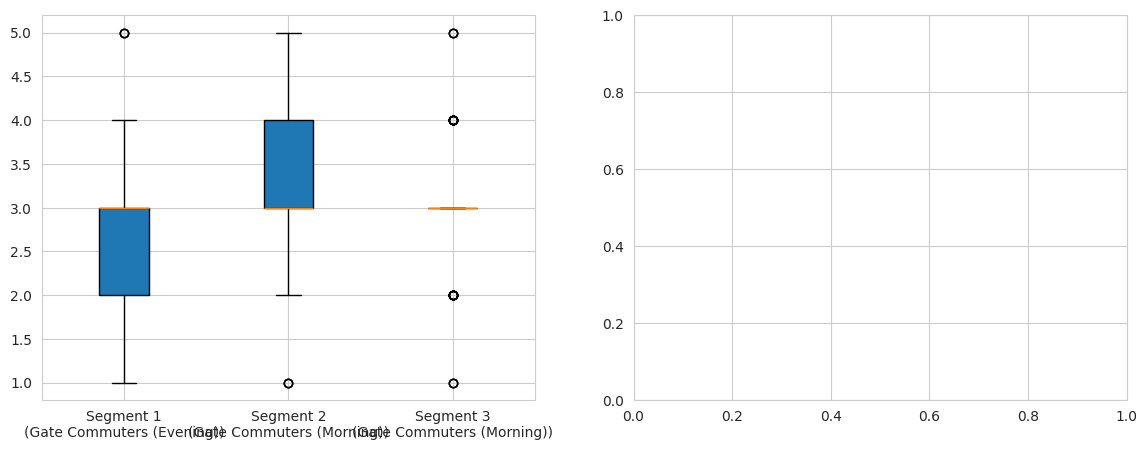

In [10]:
# ============================================================================
# ШАГ 5: Проверка различий по satisfaction и frequency
# ============================================================================

# FIGURE 3: Satisfaction по сегментам
if 'Overall_Satisfaction' in df_analysis.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot
    satisfaction_data = []
    segment_labels = []
    for seg in sorted(df_analysis['Segment'].unique()):
        seg_sat = df_analysis[df_analysis['Segment'] == seg]['Overall_Satisfaction'].dropna()
        satisfaction_data.append(seg_sat.values)
        segment_labels.append(f'Segment {seg+1}\n({segment_names[seg]})')
    
    bp = axes[0].boxplot(satisfaction_data, labels=segment_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[0].set_title('Overall Satisfaction by Segment', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Satisfaction Score', fontsize=11)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Kruskal-Wallis test
    stat, p_value = kruskal(*satisfaction_data)
    axes[0].text(0.5, 0.95, f'Kruskal-Wallis: H={stat:.2f}, p={p_value:.4f}',
                 transform=axes[0].transAxes, ha='center', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Violin plot
    sat_df = df_analysis[['Segment', 'Overall_Satisfaction']].dropna()
    sat_df['Segment_Label'] = sat_df['Segment'].apply(
        lambda x: f'Segment {x+1}\n({segment_names[x]})'
    )
    sns.violinplot(data=sat_df, x='Segment_Label', y='Overall_Satisfaction', 
                   ax=axes[1], palette=colors)
    axes[1].set_title('Satisfaction Distribution by Segment', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Satisfaction Score', fontsize=11)
    axes[1].set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nKruskal-Wallis test for satisfaction: H={stat:.3f}, p={p_value:.4f}")
    if p_value < 0.05:
        print("  → Segments differ significantly in satisfaction (p < 0.05)")

# Frequency analysis - ИСПРАВЛЕНО: тестируем на общую интенсивность использования
# Вариант 1: Использовать Total_Usage_Score (если он есть и корректно вычислен)
if 'Total_Usage_Score' in df_analysis.columns:
    freq_data = []
    for seg in sorted(df_analysis['Segment'].unique()):
        seg_freq = df_analysis[df_analysis['Segment'] == seg]['Total_Usage_Score'].dropna()
        freq_data.append(seg_freq.values)
    
    if len(freq_data) > 0 and all(len(d) > 0 for d in freq_data):
        stat_freq, p_freq = kruskal(*freq_data)
        print(f"\nKruskal-Wallis test for total usage frequency: H={stat_freq:.3f}, p={p_freq:.4f}")
        if p_freq < 0.05:
            print("  → Segments differ significantly in total usage frequency (p < 0.05)")
        
        # Визуализация общей частоты использования
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Box plot
        bp = axes[0].boxplot(freq_data, labels=[f'Segment {i+1}\n({segment_names[i]})' 
                                                  for i in sorted(df_analysis['Segment'].unique())], 
                             patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(freq_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[0].set_title('Total Usage Frequency by Segment', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Total Usage Score', fontsize=11)
        axes[0].grid(axis='y', alpha=0.3)
        axes[0].text(0.5, 0.95, f'Kruskal-Wallis: H={stat_freq:.2f}, p={p_freq:.4f}',
                     transform=axes[0].transAxes, ha='center', va='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Violin plot
        freq_df = df_analysis[['Segment', 'Total_Usage_Score']].dropna()
        freq_df['Segment_Label'] = freq_df['Segment'].apply(
            lambda x: f'Segment {x+1}\n({segment_names[x]})'
        )
        sns.violinplot(data=freq_df, x='Segment_Label', y='Total_Usage_Score', 
                       ax=axes[1], palette=colors)
        axes[1].set_title('Usage Frequency Distribution by Segment', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Total Usage Score', fontsize=11)
        axes[1].set_xlabel('')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()

# Вариант 2: Если Total_Usage_Score нет или он некорректен, создаём комбинированный показатель
elif 'Weekday_Ring_Frequency' in df_analysis.columns and 'Weekend_Ring_Frequency' in df_analysis.columns:
    # Создаём комбинированный показатель: сумма weekday + weekend
    df_analysis['Combined_Frequency'] = (
        df_analysis['Weekday_Ring_Frequency'].fillna(0) + 
        df_analysis['Weekend_Ring_Frequency'].fillna(0)
    )
    
    freq_data = []
    for seg in sorted(df_analysis['Segment'].unique()):
        seg_freq = df_analysis[df_analysis['Segment'] == seg]['Combined_Frequency'].dropna()
        # Убираем нули, если они означают отсутствие данных
        seg_freq = seg_freq[seg_freq > 0]
        if len(seg_freq) > 0:
            freq_data.append(seg_freq.values)
    
    if len(freq_data) > 0 and all(len(d) > 0 for d in freq_data):
        stat_freq, p_freq = kruskal(*freq_data)
        print(f"\nKruskal-Wallis test for combined (weekday + weekend) frequency: H={stat_freq:.3f}, p={p_freq:.4f}")
        if p_freq < 0.05:
            print("  → Segments differ significantly in combined usage frequency (p < 0.05)")
        
        # Визуализация комбинированной частоты
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        bp = axes[0].boxplot(freq_data, labels=[f'Segment {i+1}\n({segment_names[i]})' 
                                                 for i in sorted(df_analysis['Segment'].unique())], 
                             patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(freq_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[0].set_title('Combined Usage Frequency (Weekday + Weekend) by Segment', 
                         fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Combined Frequency Score', fontsize=11)
        axes[0].grid(axis='y', alpha=0.3)
        axes[0].text(0.5, 0.95, f'Kruskal-Wallis: H={stat_freq:.2f}, p={p_freq:.4f}',
                     transform=axes[0].transAxes, ha='center', va='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        freq_df = df_analysis[['Segment', 'Combined_Frequency']].dropna()
        freq_df = freq_df[freq_df['Combined_Frequency'] > 0]
        freq_df['Segment_Label'] = freq_df['Segment'].apply(
            lambda x: f'Segment {x+1}\n({segment_names[x]})'
        )
        sns.violinplot(data=freq_df, x='Segment_Label', y='Combined_Frequency', 
                       ax=axes[1], palette=colors)
        axes[1].set_title('Combined Frequency Distribution by Segment', 
                         fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Combined Frequency Score', fontsize=11)
        axes[1].set_xlabel('')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()

# Дополнительно: можно протестировать weekday и weekend отдельно для полноты картины
print("\n--- Additional: Separate weekday/weekend analysis ---")
if 'Weekday_Ring_Frequency' in df_analysis.columns:
    freq_wd_data = []
    for seg in sorted(df_analysis['Segment'].unique()):
        seg_freq = df_analysis[df_analysis['Segment'] == seg]['Weekday_Ring_Frequency'].dropna()
        freq_wd_data.append(seg_freq.values)
    
    if len(freq_wd_data) > 0 and all(len(d) > 0 for d in freq_wd_data):
        stat_wd, p_wd = kruskal(*freq_wd_data)
        print(f"Weekday frequency: H={stat_wd:.3f}, p={p_wd:.4f}")
        if p_wd < 0.05:
            print("  → Segments differ significantly in weekday frequency (p < 0.05)")

if 'Weekend_Ring_Frequency' in df_analysis.columns:
    freq_we_data = []
    for seg in sorted(df_analysis['Segment'].unique()):
        seg_freq = df_analysis[df_analysis['Segment'] == seg]['Weekend_Ring_Frequency'].dropna()
        freq_we_data.append(seg_freq.values)
    
    if len(freq_we_data) > 0 and all(len(d) > 0 for d in freq_we_data):
        stat_we, p_we = kruskal(*freq_we_data)
        print(f"Weekend frequency: H={stat_we:.3f}, p={p_we:.4f}")
        if p_we < 0.05:
            print("  → Segments differ significantly in weekend frequency (p < 0.05)")


In [ ]:
!uv pip install pylca

Using Python 3.13.11 environment at: /home/master/Documents/private/uni/sem_5/survey_techniques/project/metu_ring_analysis/.venv
Audited 1 package in 12ms


In [ ]:
# Установка: pip install pylca
# ВНИМАНИЕ: pylca может быть не той библиотекой для Latent Class Analysis
# Проверяем сигнатуру конструктора
from pylca import LCA
import inspect

try:
    sig = inspect.signature(LCA.__init__)
    print("LCA constructor parameters:", list(sig.parameters.keys()))
except:
    print("Не удалось получить сигнатуру")

# Попробуем создать модель без параметров
try:
    test_model = LCA()
    print("LCA() создан успешно без параметров")
except Exception as e:
    print(f"Ошибка при создании LCA(): {e}")

# Подготовка данных (как выше)
# ...

# LCA анализ
# pylca может не поддерживать стандартный API для Latent Class Analysis
# Используем альтернативный подход: вычисляем BIC для разных k через кластеризацию

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score

# Определяем функцию jaccard_distance (если еще не определена)
def jaccard_distance(x, y):
    """Вычисляет расстояние Жаккара между двумя бинарными векторами"""
    intersection = np.logical_and(x, y).sum()
    union = np.logical_or(x, y).sum()
    if union == 0:
        return 1.0
    return 1 - (intersection / union)

print("\nВычисляем BIC для разных значений k через иерархическую кластеризацию...")

# Вычисляем расстояния
distances = pdist(X[behavior_cols].values, metric=jaccard_distance)
linkage_matrix = linkage(distances, method='ward')
distance_matrix = squareform(distances)
np.fill_diagonal(distance_matrix, 0)

best_bic = np.inf
best_model_labels = None
best_k = 3

for k in range(2, 7):
    labels = fcluster(linkage_matrix, k, criterion='maxclust')
    
    if len(np.unique(labels)) > 1:
        # Вычисляем BIC приближенно (упрощенная формула)
        n = len(X)
        n_params = k * X[behavior_cols].shape[1]  # приблизительное число параметров
        log_likelihood = -silhouette_score(distance_matrix, labels, metric='precomputed') * n
        
        # BIC = -2 * log_likelihood + n_params * log(n)
        bic = -2 * log_likelihood + n_params * np.log(n)
        
        print(f"K={k}: BIC={bic:.2f}")
        
        if bic < best_bic:
            best_bic = bic
            best_model_labels = labels
            best_k = k

print(f"\nBest model: K={best_k}, BIC={best_bic:.2f}")

# Получаем метки кластеров
cluster_labels = best_model_labels - 1  # Приводим к 0-based индексации
df_analysis['Segment'] = cluster_labels

# Вычисляем вероятности для каждого класса (аналог class_probs и item_probs)
class_probs = pd.Series(cluster_labels).value_counts(normalize=True).sort_index()
item_probs = {}
for seg in sorted(df_analysis['Segment'].unique()):
    seg_data = X[behavior_cols][df_analysis['Segment'] == seg]
    item_probs[seg] = seg_data.mean()

print(f"\nClass probabilities: {class_probs.to_dict()}")
print(f"Item probabilities computed for {len(item_probs)} segments")

LCA constructor parameters: ['self', 'n_units', 'dt_t', 'leak', 'competition', 'self_excit', 'w_input', 'w_cross', 'offset', 'noise_sd']
Ошибка при создании LCA(): LCA.__init__() missing 4 required positional arguments: 'n_units', 'dt_t', 'leak', and 'competition'

Вычисляем BIC для разных значений k через иерархическую кластеризацию...
K=2: BIC=316.48
K=3: BIC=455.20
K=4: BIC=581.67
K=5: BIC=714.80
K=6: BIC=841.95

Best model: K=2, BIC=316.48

Class probabilities: {0: 0.4430769230769231, 1: 0.556923076923077}
Item probabilities computed for 2 segments
